## Sampling plans in the Familiar setting
This notebook steps through the *Familiar* setting of the case study of [*paper here*].
The goal is to illustrate how post-market surveillance (PMS) data, regulator priors on substandard and falsified product
(SFP) rates in a supply chain, and an encoding of regulatory objectives can be integrated towards designating sampling
plans.
See [*paper*] for more details.

This notebook uses the `logistigate` software package to conduct analysis; first import this package:

In [1]:
# CLEAN UP LATER
from logistigate.logistigate import utilities as util # Pull from the submodule "develop" branch
from logistigate.logistigate import methods
from logistigate.logistigate.priors import prior_normal_assort
from logistigate.logistigate import lossfunctions as lf
from logistigate.logistigate import samplingplanfunctions as sampf

import os
import numpy as np
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt

from numpy.random import choice
import scipy.special as sps

We then build a `logistigate` data dictionary containing prior data for 4 test nodes (provinces) and 13 supply nodes
(manufacturers). `Nfam` is a matrix of tests along each test node-supply node trace, and `Yfam' is a matrix of testing
positives along these traces.

In [2]:
Nfam = np.array([[1., 1., 10., 1., 3., 0., 1., 6., 7., 5., 0., 0., 4.],
                      [1., 1., 4., 2., 0., 1., 1., 2., 0., 4., 0., 0., 1.],
                      [3., 17., 31., 4., 2., 0., 1., 6., 0., 23., 1., 2., 5.],
                      [1., 1., 15., 2., 0., 0., 0., 1., 0., 6., 0., 0., 0.]])
Yfam = np.array([[0., 0., 7., 0., 3., 0., 1., 0., 1., 0., 0., 0., 4.],
                      [0., 0., 2., 2., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
                      [0., 0., 15., 3., 2., 0., 0., 2., 0., 1., 1., 2., 5.],
                      [0., 0., 5., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
(numTN, numSN) = Nfam.shape # For later use
csdict_fam = util.initDataDict(Nfam, Yfam) # Initialize necessary logistigate keys
csdict_fam['TNnames'] = ['MOD_39', 'MOD_17', 'MODHIGH_95', 'MODHIGH_26']
csdict_fam['SNnames'] = ['MNFR ' + str(i+1) for i in range(numSN)]

# Some summaries
TNtesttotals = np.sum(Nfam, axis=1)
TNsfptotals = np.sum(Yfam, axis=1)
TNrates = np.divide(TNsfptotals,TNtesttotals)
print('Tests at each test node:')
print(TNtesttotals)
print('Positives at each test node:')
print(TNsfptotals)
print('Positive rates at each test node:')
print(TNrates)

Tests at each test node:
[39. 17. 95. 26.]
Positives at each test node:
[16.  8. 31.  7.]
Positive rates at each test node:
[0.41025641 0.47058824 0.32631579 0.26923077]


We then need to incorporate a prior on SFP rates at each node in the supply chain, so a set of initial MCMC draws can
be generated:

Generating posterior samples...
Posterior samples generated


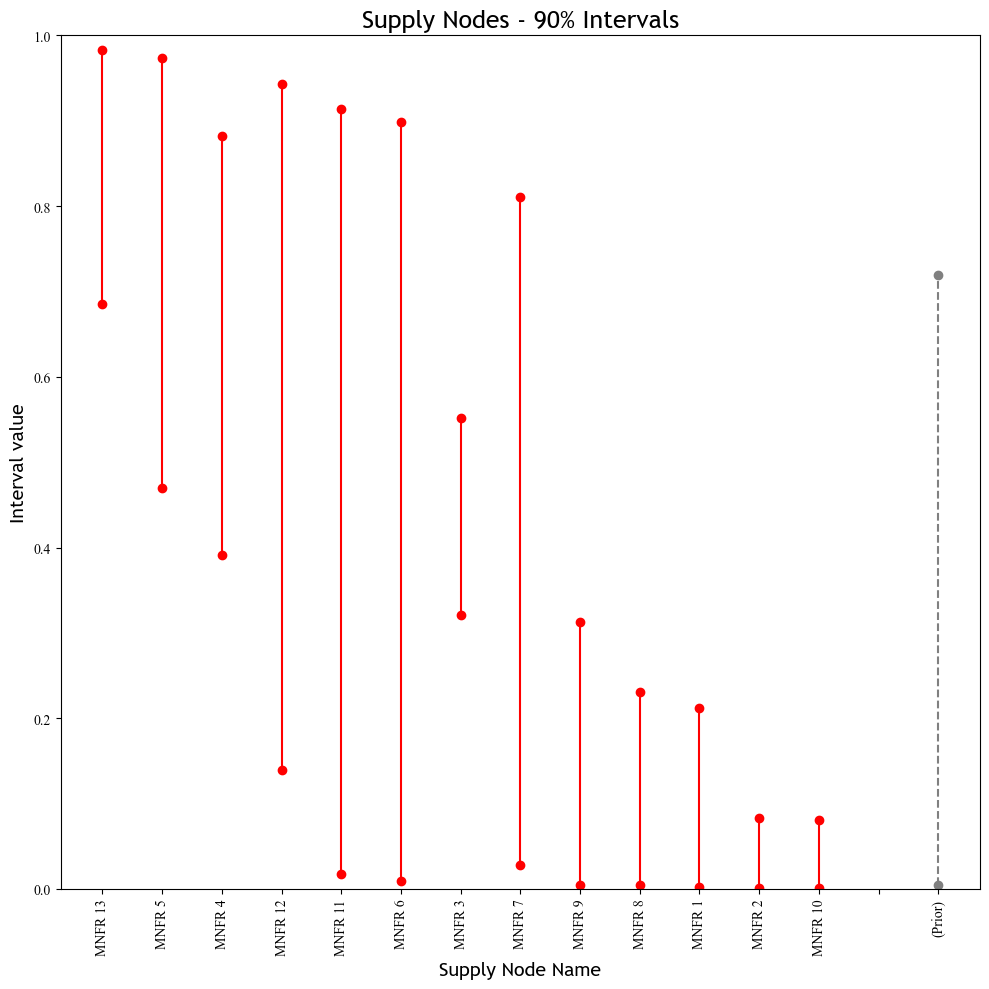

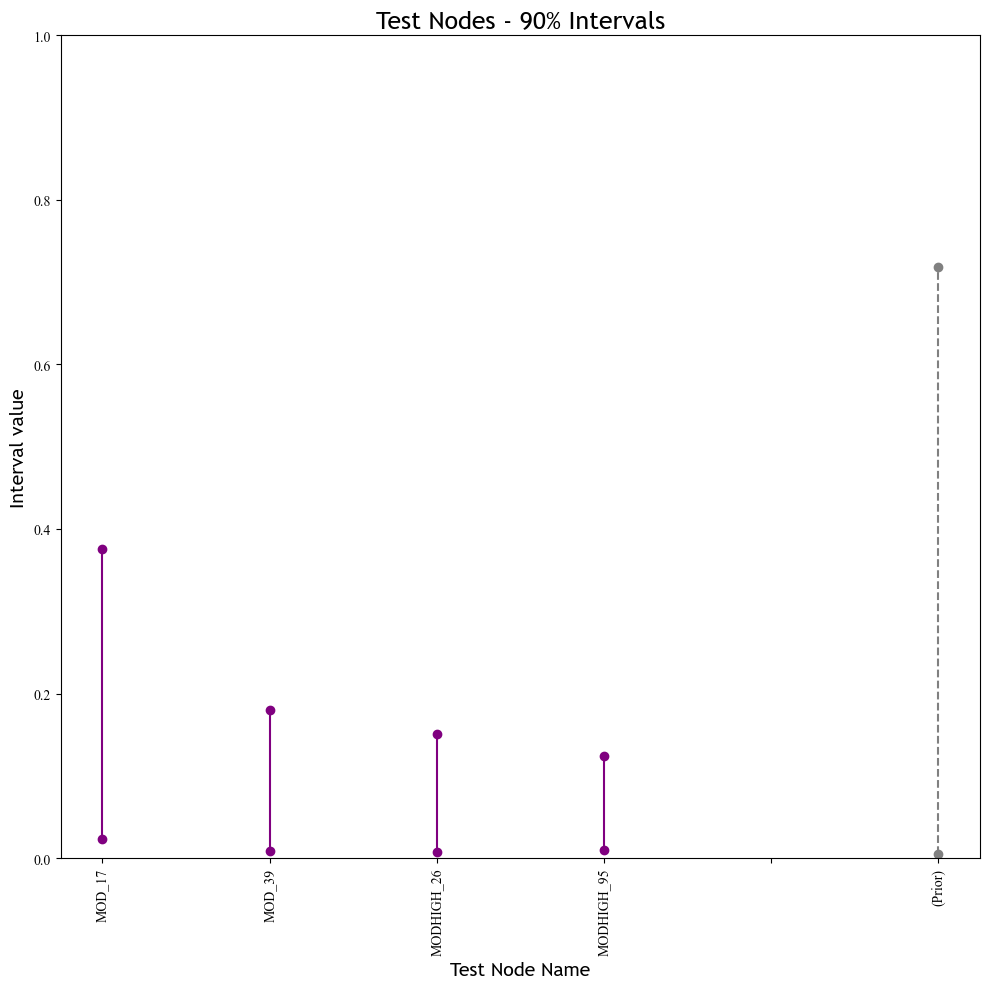

In [3]:
# Build prior
SNpriorMean = np.repeat(sps.logit(0.1), numSN)
# Establish test node priors according to assessment by regulators
TNpriorMean = sps.logit(np.array([0.1, 0.1, 0.15, 0.15]))
priorMean = np.concatenate((SNpriorMean, TNpriorMean))
TNvar, SNvar = 2., 4.  # Variances for use with prior; supply nodes are wide due to large
priorCovar = np.diag(np.concatenate((np.repeat(SNvar, numSN), np.repeat(TNvar, numTN))))
priorObj = prior_normal_assort(priorMean, priorCovar)
csdict_fam['prior'] = priorObj

# Set up MCMC
csdict_fam['MCMCdict'] = {'MCMCtype': 'NUTS', 'Madapt': 5000, 'delta': 0.4}
# Generate posterior draws
numdraws = 10000
csdict_fam['numPostSamples'] = numdraws
np.random.seed(1000) # To replicate draws later
csdict_fam = methods.GeneratePostSamples(csdict_fam)
# Print inference from initial data
util.plotPostSamples(csdict_fam, 'int90')

Sampling plan evaluation requires specification of the loss as well as estimation parameters, stored in `paramdict`:

In [7]:
# Loss specification
paramdict = lf.build_diffscore_checkrisk_dict(scoreunderestwt=5., riskthreshold=0.15, riskslope=0.6,
                                              marketvec=np.ones(numTN + numSN))

# Set limits of data collection and intervals for calculation
testmax, testint = 400, 10
testarr = np.arange(testint, testmax + testint, testint)

Next set algorithm parameters, including the draws to use as truth draws and data draws.
Plan utility is calculated at each test node for each testing interval.

In [8]:
# Set MCMC draws to use in fast algorithm
numtruthdraws, numdatadraws = 3000, 1500

# Get random subsets for truth and data draws
truthdraws, datadraws = util.distribute_truthdata_draws(csdict_fam['postSamples'], numtruthdraws, numdatadraws)

paramdict.update({'truthdraws': truthdraws, 'datadraws': datadraws})

The `baseloss` is the loss when conducting no additional tests; plan utility is the difference between the plan's loss
and `baseloss`.

In [9]:
paramdict['baseloss'] = sampf.baseloss(paramdict['truthdraws'], paramdict)

Loop through each test node and budget, and save the list of losses for each data draw:

Estimating plan utility with following parameters...
Absolute difference score with underestimation penalty of 5.0
Check risk with threshold of 0.15 and slope of 0.6
Truth draws: 4000
Data draws: 1000
Baseline loss: 2.4023026176464284
Design: [1. 0. 0. 0.]
Utility for 10 tests: 0.04155700724894462
Utility for 20 tests: 0.07522424843850972
Utility for 30 tests: 0.10724438834443673
Utility for 40 tests: 0.13693452538927176
Utility for 50 tests: 0.15835240980828935
Utility for 60 tests: 0.19122493563280774
Utility for 70 tests: 0.21222345329536596
Utility for 80 tests: 0.23099042139386539
Utility for 90 tests: 0.2598555067381705
Utility for 100 tests: 0.2767700542687286
Utility for 110 tests: 0.3012507626714407
Utility for 120 tests: 0.32027105804743483
Utility for 130 tests: 0.33801940421034526
Utility for 140 tests: 0.3588696133940408
Utility for 150 tests: 0.378416567528689
Utility for 160 tests: 0.3971700193177039
Utility for 170 tests: 0.42577232313401003
Utility for 180 tests: 0.439

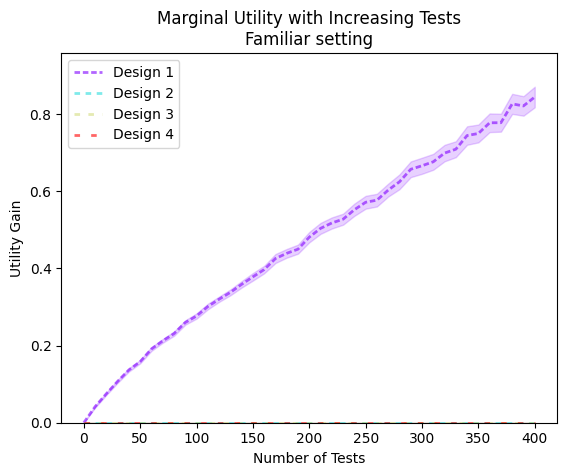

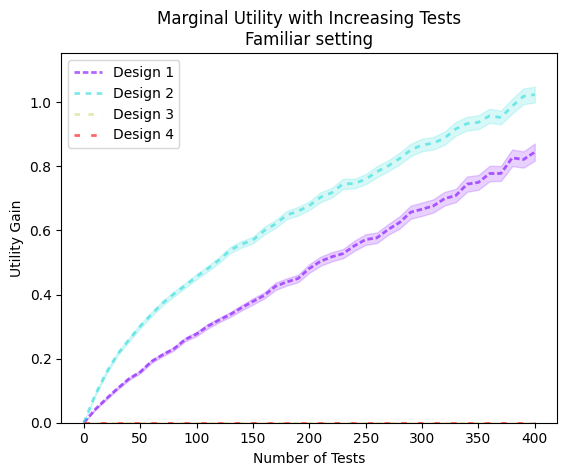

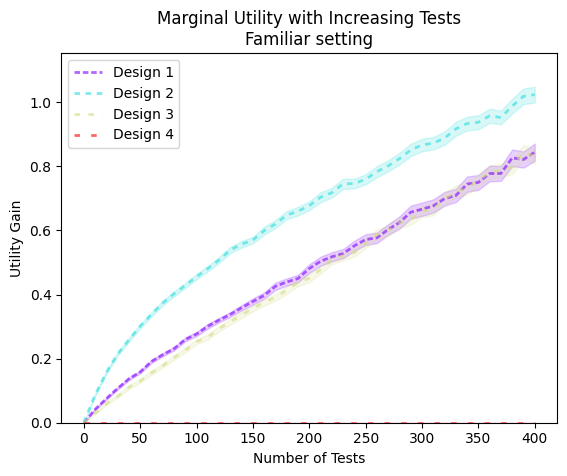

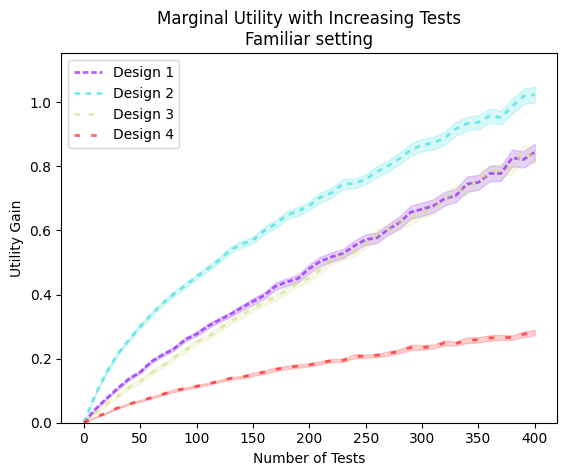

In [8]:
# Initialize the return arrays
margutil_avg_arr = np.zeros((numTN, int(testmax / testint) + 1))
margutil_lo_arr, margutil_hi_arr = np.zeros((numTN, int(testmax / testint) + 1)), np.zeros((numTN, int(testmax / testint) + 1))

# Loop through each test node and budget and get the utility
util.print_param_checks(paramdict) # Check of used parameters
printupdate, plotupdate = True, False

# THIS LOOP TO BE PUT INTO A WRAPPER FUNCTION IN LOGISTIGATE
for currTN in range(numTN):
    design = np.zeros(numTN)
    design[currTN] = 1.
    if printupdate == True:
        print('Design: ' + str(design.round(2)))
    for testnum in range(testint, testmax+1, testint):
        # Get a list of losses corresponding to each data draw
        currlosslist = sampf.sampling_plan_loss_list(design, testnum, csdict_fam, paramdict)
        # Set desired confidence level as second argument to process_list_loss()
        avg_loss, avg_loss_CI = sampf.process_loss_list(currlosslist, 0.95)
        margutil_avg_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss
        margutil_hi_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss_CI[0]
        margutil_lo_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss_CI[1]
        if printupdate == True:
            print('Utility for '+str(testnum)+' tests: ' + str(paramdict['baseloss'] - avg_loss))
    if plotupdate == True:
        util.plot_marg_util_CI(margutil_avg_arr, margutilarr_hi=margutil_hi_arr,
                               margutilarr_lo=margutil_lo_arr, testmax=testmax, testint=testint,
                               titlestr='Familiar setting')

Plot all utilities:

In [10]:
util.plot_marg_util_CI(margutil_avg_arr, margutilarr_hi=margutil_hi_arr,
                                   margutilarr_lo=margutil_lo_arr, testmax=testmax, testint=testint,
                                   titlestr='Familiar setting')

NameError: name 'margutil_avg_arr' is not defined

Save the utility estimates for later use:

In [ ]:
np.save(os.path.join('casestudyoutputs', '31MAY', 'margutil_avg_arr_fam'), margutil_avg_arr)
np.save(os.path.join('casestudyoutputs', '31MAY', 'margutil_hi_arr_fam'), margutil_hi_arr)
np.save(os.path.join('casestudyoutputs', '31MAY', 'margutil_lo_arr_fam'), margutil_lo_arr)

margutil_avg_arr = np.load(os.path.join('casestudyoutputs', '31MAY', 'margutil_avg_arr_fam.npy'))
margutil_hi_arr = np.load(os.path.join('casestudyoutputs', '31MAY', 'margutil_hi_arr_fam.npy'))
margutil_lo_arr = np.load(os.path.join('casestudyoutputs', '31MAY', 'margutil_lo_arr_fam.npy'))

Form an allocation using a greedy algorithm:

In [5]:
allocArr, objValArr = sampf.smooth_alloc_forward(margutil_avg_arr)
util.plot_plan(allocArr, paramList=[str(i) for i in np.arange(testint, testmax + 1, testint)], testInt=testint,
          labels=csdict_fam['TNnames'], titleStr='Familiar Setting, $t=0.15$, $m=0.6$', allocMax=250,
          colors=cm.rainbow(np.linspace(0, 0.5, numTN)), dashes=[[1, 0] for tn in range(numTN)])

Next we campare the heuristic allocation utility with the utility under the Uniform and Rudimentary policies.

In [8]:
# Now get comprehensive utilities for different sampling plans; use different set of MCMC draws
np.random.seed(11)
csdict_fam = methods.GeneratePostSamples(csdict_fam)
# Loss specification
paramdict = lf.build_diffscore_checkrisk_dict(scoreunderestwt=5., riskthreshold=0.15, riskslope=0.6,
                                              marketvec=np.ones(numTN + numSN))
# Set MCMC draws to use in fast algorithm
numtruthdraws, numdatadraws = 4000, 1000
truthdraws, datadraws = util.distribute_truthdata_draws(csdict_fam['postSamples'], numtruthdraws, numdatadraws)
paramdict.update({'truthdraws': truthdraws, 'datadraws': datadraws})
paramdict['baseloss'] = sampf.baseloss(paramdict['truthdraws'], paramdict)
# Set limits of data collection and intervals for calculation
testmax, testint = 400, 10
testarr = np.arange(testint, testmax + testint, testint)





# Initialize the return arrays
margutil_avg_arr = np.zeros((numTN, int(testmax / testint) + 1))
margutil_lo_arr, margutil_hi_arr = np.zeros((numTN, int(testmax / testint) + 1)), np.zeros((numTN, int(testmax / testint) + 1))

design = np.zeros(numTN)
    design[currTN] = 1.
    if printupdate == True:
        print('Design: ' + str(design.round(2)))
    for testnum in range(testint, testmax+1, testint):
        # Get a list of losses corresponding to each data draw
        currlosslist = sampf.sampling_plan_loss_list(design, testnum, csdict_fam, paramdict)
        # Set desired confidence level as second argument to process_list_loss()
        avg_loss, avg_loss_CI = sampf.process_loss_list(currlosslist, 0.95)
        margutil_avg_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss
        margutil_hi_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss_CI[0]
        margutil_lo_arr[currTN][int(testnum / testint)] = paramdict['baseloss'] - avg_loss_CI[1]


heur_utillist, unif_utillist, rudi_utillist = [], [], [] #  Initialize storage lists
numReps = 10
for rep in range(numReps):
    # Pull relevant draws
    currcanddraws = csdict_fam['postSamples'][indsList[rep]]
    currtruthdraws = currcanddraws[choice(np.arange(numcanddraws), size=numtruthdraws, replace=False)]
    currdatadraws = currtruthdraws[choice(np.arange(numtruthdraws), size=numdatadraws, replace=False)]
    # Update paramdict
    paramdict.update({'canddraws': currcanddraws, 'truthdraws': currtruthdraws, 'datadraws': currdatadraws})
    # Build loss matrix
    lossmatrix = lf.build_loss_matrix(currtruthdraws, currcanddraws, paramdict)
    baseloss = sampf.baseloss(lossmatrix)
    paramdict.update({'lossmatrix': lossmatrix})
    # Checks
    print('Candidate draws: ' + str(paramdict['lossmatrix'].shape[0]))
    print('Truth draws: ' + str(paramdict['lossmatrix'].shape[1]))
    print('Data draws: ' + str(paramdict['datadraws'].shape[0]))
    print('Baseline loss: ' + str(baseloss))
    # Iterate through each design and sampling budget and obtain utility
    curr_heur_utillist, curr_unif_utillist, curr_rudi_utillist = [], [], []
    for testInd in range(testarr.shape[0]):
        # Heuristic design
        heur_des = allocArr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=heur_des, numtests=testarr[testInd],
                                                                priordatadict=csdict_fam, paramdict=paramdict)
        curr_heur_utillist.append(currUtil)
        # Uniform design
        unif_des = util.round_design_low(np.ones(numTN) / numTN, testarr[testInd]) / testarr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=unif_des, numtests=testarr[testInd],
                                                            priordatadict=csdict_fam, paramdict=paramdict)
        curr_unif_utillist.append(currUtil)
        # Rudimentary design
        rudi_des = util.round_design_low(np.divide(np.sum(Nfam, axis=1), np.sum(Nfam)), testarr[testInd]) / testarr[testInd]
        currUtil = baseloss - sampf.sampling_plan_loss_fast(design=rudi_des, numtests=testarr[testInd],
                                                            priordatadict=csdict_fam, paramdict=paramdict)
        curr_rudi_utillist.append(currUtil)
    print('Utility matrices for replication ' + str(rep) + ':')
    print(curr_heur_utillist)
    print(curr_unif_utillist)
    print(curr_rudi_utillist)
    heur_utillist.append(curr_heur_utillist)
    unif_utillist.append(curr_unif_utillist)
    rudi_utillist.append(curr_rudi_utillist)

In [ ]:
# OPTIONAL
# np.save(os.path.join('casestudyoutputs', '16MAY', 'heur_utillist_familiar'), np.array(heur_utillist))
# np.save(os.path.join('casestudyoutputs', '16MAY', 'unif_utillist_familiar'), np.array(unif_utillist))
# np.save(os.path.join('casestudyoutputs', '16MAY', 'rudi_utillist_familiar'), np.array(rudi_utillist))

In [11]:
heur_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'Familiar', 'heur_utillist_familiar.npy'))
unif_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'unif_utillist_familiar.npy'))
rudi_utillist = np.load(os.path.join('casestudyoutputs', 'PREVIOUS', 'rudi_utillist_familiar.npy'))

## Adding a market term
We next consider the use of a market term weighing each test node and supply node by the catchment area it represents.



In [ ]:
# Region catchment proportions, for market terms
TNcach = np.array([0.17646, 0.05752, 0.09275, 0.09488])
TNcach = TNcach[:4] / np.sum(TNcach[:4])
SNcach = np.matmul(TNcach, csdict_fam['Q'])